<a href="https://colab.research.google.com/github/Raspberry765/deep-metric-learning/blob/main/outlier_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu
!pip install torchsummary
!pip install plotly==5.14.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 86.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from torchsummary import summary
import plotly.express as px
import plotly.graph_objects as go
from torch.utils.data.dataset import Subset
from torchvision.models.feature_extraction import create_feature_extractor

In [3]:


img_mean, img_std = (0.1307,), (0.3081,) #MNISTの平均と標準偏差  https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457 


inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(img_mean, img_std)], std=[1 / s for s in img_std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def imshow_many(dataset, outliers, n=32):
    imgs = [
        dataset[outliers[i]][0]
        for i in np.random.choice(
            len(outliers), size=min(n, len(outliers)), replace=False
        )
    ]
    imshow(torchvision.utils.make_grid(imgs))

In [4]:

device = torch.device("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(img_mean, img_std)]
) #MNISTの平均と標準偏差を画像に対して前処理を行うためのパラメーター



dataset1 = datasets.MNIST("./sample_data/", train=True, download=True, transform=transform) #トランスフォームを適用して、ダウンロード
dataset2 = datasets.MNIST("./sample_data/", train=False, transform=transform) #トランスフォームを適用して、ダウンロード



100%|██████████| 9912422/9912422 [00:00<00:00, 227253011.74it/s]

Extracting ./sample_data/MNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 100611041.38it/s]


Extracting ./sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 59574558.93it/s]


Extracting ./sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13482327.51it/s]


Extracting ./sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


AttributeError: ignored

In [6]:
device = torch.device("cuda")

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1)
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #MNISTのデータはグレースケールだから、channel数は1である
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(15488, 256)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        ##torch.nn.functional.max_pool2d(input, kernel_size, stride=kernel_size)
        #max_pool2dのstrideのデフォルトはkernel_size
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        #loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=256).to(device) #0~9の数字を分類するため　10classに分類する、embedding_sizeは最終出力のunits数
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))
            numpy_loss = loss.cpu().detach().numpy()
            loss_list.append(numpy_loss)
            torch.save(model, "model_dml"+ str(epoch)+ "_" + str(batch_idx)  + ".pth")
            #print(numpy_loss)            
    return loss_list


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


import __main__
setattr(__main__, "Net", Net)
model = torch.load('/content/drive/MyDrive/deep_metric_learning/model_dml.pth', map_location=device)

100%|██████████| 1875/1875 [00:24<00:00, 76.51it/s]


There are 60000 outliers


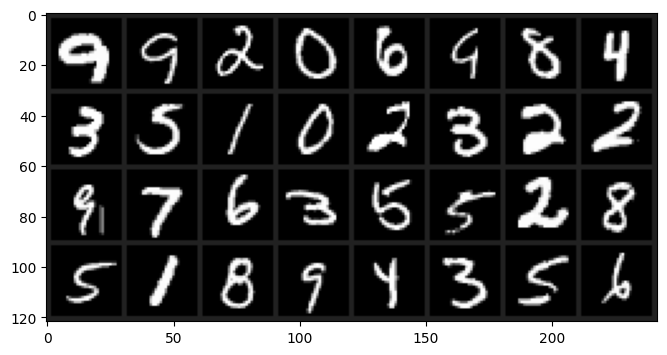

In [9]:
train_embeddings, train_labels = get_all_embeddings(dataset1, model)

### pytorch-metric-learning stuff ###
loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=256).to(device) #0~9の数字を分類するため　10classに分類する、embedding_sizeは最終出力のunits数
### pytorch-metric-learning stuff ###

outliers, _ = loss_func.get_outliers(train_embeddings, train_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers")
imshow_many(dataset1, outliers)